In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
import keras

### 데이터 로드

In [2]:
GGG_df = pd.read_csv("./custom_data/GGG_df_no_interpolation.csv", index_col=0)
GGI_df = pd.read_csv("./custom_data/GGI_df_no_interpolation.csv", index_col=0)
GGJ_df = pd.read_csv("./custom_data/GGJ_df_no_interpolation.csv", index_col=0)

In [3]:
tmp = pd.DataFrame()

tmp['Bx_Gangneung'] = GGG_df['X']
tmp['By_Gangneung'] = GGG_df['Y']
tmp['Bz_Gangneung'] = GGG_df['Z']

tmp['Bx_Icheon'] = GGI_df['X']
tmp['By_Icheon'] = GGI_df['Y']
tmp['Bz_Icheon'] = GGI_df['Z']

tmp['Bx_Jeju'] = GGJ_df['X']
tmp['By_Jeju'] = GGJ_df['Y']
tmp['Bz_Jeju'] = GGJ_df['Z']

tmp2 = tmp.copy()

### 회귀 모델 Load

In [4]:
model_Gx2Ix = keras.models.load_model('./model_rg/model_Gx2Ix.h5')
model_Jx2Ix = keras.models.load_model('./model_rg/model_Jx2Ix.h5')
model_Gy2Iy = keras.models.load_model('./model_rg/model_Gy2Iy.h5')
model_Jy2Iy = keras.models.load_model('./model_rg/model_Jy2Iy.h5')
model_Gz2Iz = keras.models.load_model('./model_rg/model_Gz2Iz.h5')
model_Jz2Iz = keras.models.load_model('./model_rg/model_Jz2Iz.h5')

model_Ix2Jx = keras.models.load_model('./model_rg/model_Ix2Jx.h5')
model_Gx2Jx = keras.models.load_model('./model_rg/model_Gx2Jx.h5')
model_Iy2Jy = keras.models.load_model('./model_rg/model_Iy2Jy.h5')
model_Gy2Jy = keras.models.load_model('./model_rg/model_Gy2Jy.h5')
model_Iz2Jz = keras.models.load_model('./model_rg/model_Iz2Jz.h5')
model_Gz2Jz = keras.models.load_model('./model_rg/model_Gz2Jz.h5')

model_Ix2Gx = keras.models.load_model('./model_rg/model_Ix2Gx.h5')
model_Jx2Gx = keras.models.load_model('./model_rg/model_Jx2Gx.h5')
model_Iy2Gy = keras.models.load_model('./model_rg/model_Iy2Gy.h5')
model_Jy2Gy = keras.models.load_model('./model_rg/model_Jy2Gy.h5')
model_Iz2Gz = keras.models.load_model('./model_rg/model_Iz2Gz.h5')
model_Jz2Gz = keras.models.load_model('./model_rg/model_Jz2Gz.h5')

2022-10-26 14:26:48.431068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 14:26:49.327940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6118 MB memory:  -> device: 0, name: GRID V100DX-8C, pci bus id: 0000:02:00.0, compute capability: 7.0


In [5]:
scaler = load(open('./model_rg/standard_scaler.pkl', 'rb'))

tmp = pd.DataFrame(scaler.transform(tmp), columns=tmp.columns)
tmp3 = tmp.copy()

In [6]:
model_I = {'Gx2Ix':model_Gx2Ix, 'Jx2Ix':model_Jx2Ix, 'Gy2Iy':model_Gy2Iy, 'Jy2Iy':model_Jy2Iy, 'Gz2Iz':model_Gz2Iz, 'Jz2Iz':model_Jz2Iz}
model_J = {'Ix2Jx':model_Ix2Jx, 'Gx2Jx':model_Gx2Jx, 'Iy2Jy':model_Iy2Jy, 'Gy2Jy':model_Gy2Jy, 'Iz2Jz':model_Iz2Jz, 'Gz2Jz':model_Gz2Jz}
model_G = {'Ix2Gx':model_Ix2Gx, 'Jx2Gx':model_Jx2Gx, 'Iy2Gy':model_Iy2Gy, 'Jy2Gy':model_Jy2Gy, 'Iz2Gz':model_Iz2Gz, 'Jz2Gz':model_Jz2Gz}

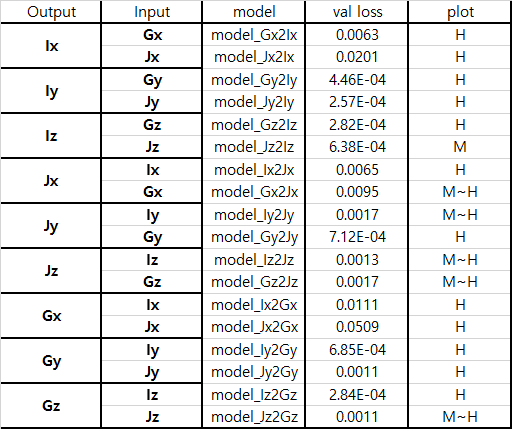

### Gx, Ix, Jx 작업

보간해야 할 데이터추출

전체 - (3개의 데이터가 모두 있는 경우 + 3개의 데이터가 모두 없는 경우)

In [7]:
TF1 = tmp.iloc[:,0].isnull().values
TF2 = tmp.iloc[:,3].isnull().values
TF3 = tmp.iloc[:,6].isnull().values

a = np.logical_and(TF1, TF2, TF3)# 모두 null이면 T 아니면 F
b = np.logical_and(~TF1, ~TF2, ~TF3)# 모두 데이터가 존재하면 T 아니면 F

nan이 1~2개 존재하는 값만 추출

In [8]:
print("전체 데이터 : {}, 모두 null인 것의 개수 : {} \n데이터가 모두 존재하는 것의 개수 : {}, 보간할 데이터의 개수 : {}".format(len(TF1), a.sum(), b.sum(), len(TF1)-a.sum()-b.sum()))

전체 데이터 : 4207680, 모두 null인 것의 개수 : 16372 
데이터가 모두 존재하는 것의 개수 : 3612495, 보간할 데이터의 개수 : 578813


In [9]:
nan_df = tmp[~np.logical_or(a, b)][['Bx_Gangneung', 'Bx_Icheon', 'Bx_Jeju']]
nan_df_X = nan_df.copy()
# 무조건 보간이 필요한 데이터, 즉 3관측소의 Bx구간이 1~2개만이 비어 있는
# 행을 모두 추출

nan_df(원본)에서 작업 후 nan_df_X의 값을 변경하는 순으로 진행

Gx 보간

In [10]:
name_interpol = 'Bx_Gangneung'

#우선순위1
name_first = 'Bx_Icheon'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'Bx_Jeju'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values#강릉 관측소의 Bx가 null인 인덱스!

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천 관측소의 Bx가 존재하는 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 이천 관측소의 인덱스 제외, 무조건 제주 관측소의 Bx는 존재하게 됨.

pred_1 = model_G[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_G[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Gx_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Gx_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

2022-10-26 14:26:51.184063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


이전에서 모두 보간


Ix 보간

In [11]:
name_interpol = 'Bx_Icheon'

#우선순위1
name_first = 'Bx_Gangneung'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'Bx_Jeju'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_I[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_I[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Ix_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Ix_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

이전에서 모두 보간


Jx 보간

In [12]:
name_interpol = 'Bx_Jeju'

#우선순위1
name_first = 'Bx_Icheon'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'Bx_Gangneung'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_J[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_J[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Jx_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Jx_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

### Gy, Iy, Jy 작업

보간해야 할 데이터추출

전체 - (3개의 데이터가 모두 있는 경우 + 3개의 데이터가 모두 없는 경우)

In [13]:
TF1 = tmp.iloc[:,1].isnull().values
TF2 = tmp.iloc[:,4].isnull().values
TF3 = tmp.iloc[:,7].isnull().values

a = np.logical_and(TF1, TF2, TF3)# 모두 null이면 T 아니면 F
b = np.logical_and(~TF1, ~TF2, ~TF3)# 모두 데이터가 존재하면 T 아니면 F

nan이 1~2개 존재하는 값만 추출

In [14]:
print("전체 데이터 : {}, 모두 null인 것의 개수 : {} \n데이터가 모두 존재하는 것의 개수 : {}, 보간할 데이터의 개수 : {}".format(len(TF1), a.sum(), b.sum(), len(TF1)-a.sum()-b.sum()))

전체 데이터 : 4207680, 모두 null인 것의 개수 : 16265 
데이터가 모두 존재하는 것의 개수 : 3605329, 보간할 데이터의 개수 : 586086


In [15]:
nan_df = tmp[~np.logical_or(a, b)][['By_Gangneung', 'By_Icheon', 'By_Jeju']]
nan_df_Y = nan_df.copy()

nan_df(원본)에서 작업 후 nan_df_Y의 값을 변경하는 순으로 진행

Gy 보간

In [16]:
name_interpol = 'By_Gangneung'

#우선순위1
name_first = 'By_Jeju'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'By_Icheon'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_G[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_G[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Gy_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Gy_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

Iy 보간

In [17]:
name_interpol = 'By_Icheon'

#우선순위1
name_first = 'By_Gangneung'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'By_Jeju'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_I[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_I[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Iy_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Iy_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

이전에서 모두 보간


Jy 보간

In [18]:
name_interpol = 'By_Jeju'

#우선순위1
name_first = 'By_Gangneung'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'By_Icheon'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_J[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_J[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Jy_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Jy_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

### Bz, Iz, Jz 작업

보간해야 할 데이터추출

전체 - (3개의 데이터가 모두 있는 경우 + 3개의 데이터가 모두 없는 경우)

In [19]:
TF1 = tmp.iloc[:,2].isnull().values
TF2 = tmp.iloc[:,5].isnull().values
TF3 = tmp.iloc[:,8].isnull().values

a = np.logical_and(TF1, TF2, TF3)# 모두 null이면 T 아니면 F
b = np.logical_and(~TF1, ~TF2, ~TF3)# 모두 데이터가 존재하면 T 아니면 F

nan이 1~2개 존재하는 값만 추출

In [20]:
print("전체 데이터 : {}, 모두 null인 것의 개수 : {} \n데이터가 모두 존재하는 것의 개수 : {}, 보간할 데이터의 개수 : {}".format(len(TF1), a.sum(), b.sum(), len(TF1)-a.sum()-b.sum()))

전체 데이터 : 4207680, 모두 null인 것의 개수 : 16207 
데이터가 모두 존재하는 것의 개수 : 3613286, 보간할 데이터의 개수 : 578187


In [21]:
nan_df = tmp[~np.logical_or(a, b)][['Bz_Gangneung', 'Bz_Icheon', 'Bz_Jeju']]
nan_df_Z = nan_df.copy()

nan_df(원본)에서 작업 후 naa_df2의 값을 변경하는 순으로 진행

Gz 보간

In [22]:
name_interpol = 'Bz_Gangneung'

#우선순위1
name_first = 'Bz_Icheon'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'Bz_Jeju'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_G[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_G[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Gz_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Gz_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

이전에서 모두 보간


Iz 보간

In [23]:
name_interpol = 'Bz_Icheon'

#우선순위1
name_first = 'Bz_Gangneung'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'Bz_Jeju'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_I[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_I[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Iz_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Iz_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

이전에서 모두 보간


Jz 보간

In [24]:
name_interpol = 'Bz_Jeju'

#우선순위1
name_first = 'Bz_Gangneung'
model_name_first = name_first[3]+name_first[1]+'2'+name_interpol[3]+name_interpol[1]
#우선순위2
name_second = 'Bz_Icheon'
model_name_second = name_second[3]+name_second[1]+'2'+name_interpol[3]+name_interpol[1]

tmp_index = nan_df[nan_df[name_interpol].isnull().values][name_first].index.values

first_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == False).values]#이천에 존재하는 데이터의 인덱스
second_idx = tmp_index[(nan_df[nan_df[name_interpol].isnull().values][name_first].isnull() == True).values]#위의 여집합, 무조건 제주에 존재해야 함.

pred_1 = model_J[model_name_first].predict(nan_df.loc[first_idx, name_first].values).tolist()
# nan_df_X.loc[first_idx, name_interpol] = pred_.reshape(-1)

try:
    pred_2 = model_J[model_name_second].predict(nan_df.loc[second_idx, name_second].values).tolist()
#     nan_df_X.loc[second_idx, name_interpol] = pred_.reshape(-1)
    Jz_interpolation = np.vstack([np.sort(np.hstack([first_idx, second_idx])), np.array(pred_1 + pred_2).reshape(-1)])
except:
    Jz_interpolation = np.vstack([first_idx, np.array(pred_1).reshape(-1)])
    print("이전에서 모두 보간")

In [25]:
print(np.shape(Gx_interpolation))
print(np.shape(Gy_interpolation))
print(np.shape(Gz_interpolation))

print(np.shape(Ix_interpolation))
print(np.shape(Iy_interpolation))
print(np.shape(Iz_interpolation))

print(np.shape(Jx_interpolation))
print(np.shape(Jy_interpolation))
print(np.shape(Jz_interpolation))

(2, 157477)
(2, 157584)
(2, 156822)
(2, 421336)
(2, 428502)
(2, 421365)
(2, 8090)
(2, 8194)
(2, 7617)


In [26]:
tmp.loc[Gx_interpolation[0], ['Bx_Gangneung']] = Gx_interpolation[1].reshape(-1, 1)
tmp.loc[Gy_interpolation[0], ['By_Gangneung']] = Gy_interpolation[1].reshape(-1, 1)
tmp.loc[Gz_interpolation[0], ['Bz_Gangneung']] = Gz_interpolation[1].reshape(-1, 1)
print("강릉 보간 완료")
tmp.loc[Ix_interpolation[0], ['Bx_Icheon']] = Ix_interpolation[1].reshape(-1, 1)
tmp.loc[Iy_interpolation[0], ['By_Icheon']] = Iy_interpolation[1].reshape(-1, 1)
tmp.loc[Iz_interpolation[0], ['Bz_Icheon']] = Iz_interpolation[1].reshape(-1, 1)
print("이천 보간 완료")
tmp.loc[Jx_interpolation[0], ['Bx_Jeju']] = Jx_interpolation[1].reshape(-1, 1)
tmp.loc[Jy_interpolation[0], ['By_Jeju']] = Jy_interpolation[1].reshape(-1, 1)
tmp.loc[Jz_interpolation[0], ['Bz_Jeju']] = Jz_interpolation[1].reshape(-1, 1)
print("제주 보간 완료")

강릉 보간 완료
이천 보간 완료
제주 보간 완료


In [27]:
tmp[['Bx_Gangneung']]

,Bx_Gangneung
0,1.984926
1,1.978915
2,1.969674
3,1.959057
4,1.952157
...,...
4207675,1.677957
4207676,1.666522
4207677,1.652281
4207678,1.637147


In [28]:
complete_interpolation = pd.DataFrame(scaler.inverse_transform(tmp), columns=tmp.columns)

In [29]:
complete_interpolation

,Bx_Gangneung,By_Gangneung,Bz_Gangneung,Bx_Icheon,By_Icheon,Bz_Icheon,Bx_Jeju,By_Jeju,Bz_Jeju
0,29648.872476,-118.679049,41083.34,29776.645734,-4283.167129,40692.172664,33230.181102,-297.188115,31625.01
1,29648.742955,-118.559052,41083.42,29779.130000,-4289.890000,40692.500000,33230.042349,-297.048132,31625.01
2,29648.543832,-118.339057,41083.37,29778.950000,-4289.640000,40692.590000,33229.884397,-296.818159,31625.02
3,29648.315066,-118.029065,41083.20,29778.770000,-4289.370000,40692.600000,33229.716622,-296.568189,31625.04
4,29648.166376,-117.699073,41083.24,29778.670000,-4289.030000,40692.660000,33229.589471,-296.248227,31625.06
...,...,...,...,...,...,...,...,...,...
4207675,29642.257972,-448.448683,41410.54,29783.870000,-4143.790000,41045.510000,33235.241395,-643.989116,31965.59
4207676,29642.011572,-448.208765,41410.48,29783.700000,-4143.470000,41045.530000,33235.147185,-643.689285,31965.52
4207677,29641.704711,-447.998835,41410.39,29783.530000,-4143.150000,41045.630000,33234.962375,-643.419435,31965.45
4207678,29641.378600,-447.738923,41410.24,29783.340000,-4142.820000,41045.670000,33234.767560,-643.149585,31965.39


In [30]:
col = tmp2.columns.values
for i in col:
    print(str(i) + " / 보간 전 : " + str(tmp2[str(i)].isnull().sum()) + " 보간 후 : " + str(complete_interpolation[str(i)].isnull().sum()))

Bx_Gangneung / 보간 전 : 173849 보간 후 : 16372
By_Gangneung / 보간 전 : 173849 보간 후 : 16265
Bz_Gangneung / 보간 전 : 173029 보간 후 : 16207
Bx_Icheon / 보간 전 : 437708 보간 후 : 16372
By_Icheon / 보간 전 : 444767 보간 후 : 16265
Bz_Icheon / 보간 전 : 437572 보간 후 : 16207
Bx_Jeju / 보간 전 : 64660 보간 후 : 56570
By_Jeju / 보간 전 : 64660 보간 후 : 56466
Bz_Jeju / 보간 전 : 62204 보간 후 : 54587


In [31]:
complete_interpolation.to_csv("custom_data/rg_interpolation.csv", mode='w')